# Lights 

> Defines a LightSchedule class and implements typical schedules used in circadian models

In [ ]:
#| default_exp lights

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *
from circadian.plots import Actogram 

In [ ]:
#| export 
import inspect
import warnings
import numpy as np
import pylab as plt
from typing import Callable
from fastcore.basics import patch_to
from numpy.core.fromnumeric import repeat

In [ ]:
#| export
class LightSchedule:
    "Helper class for creating light schedules"
    def __init__(self, 
                 light: Callable[[float], float], # light function that takes in a time value and returns a float, if a float is passed, then the light function is a constant set to that lux value 
                 period: float = None, # period in hours, if None, then the light pulse is not repeated. Must be positive
                 ) -> None:
        # period input checking
        period_err_msg = "`period` should be a positive `float` or `int`"
        if period != None:
            if not isinstance(period, (int, float)):
                raise TypeError(period_err_msg)
            elif period <= 0:
                raise ValueError(period_err_msg)
            else:
                period = float(period)
        # light input checking 
        light_input_err_msg = "`light` should be a nonnegative `float`, or a callable with a single `float` parameter which returns a `float`"
        if not callable(light):
            try:
                light = float(light)
            except:
                # catches when the provided light value can't be converted to a float
                raise TypeError(light_input_err_msg)
            if light < 0:
                # catches when the provided light value is negative
                raise ValueError(light_input_err_msg)
            else:
                # create a light function that is a constant set to the provided light value
                light_fn = lambda t: light
        else:
            if len(inspect.signature(light).parameters) != 1:
                # catches when the provided light function does not take in a single parameter
                raise ValueError(light_input_err_msg)
            else: 
                try:
                    test_output = light(0.0)
                    float(test_output)
                except:
                    # catches when the function created from light does not return values that can be cast to float
                    raise ValueError(light_input_err_msg)
            # create a light function that is the provided light function
            if period != None:
                light_fn = lambda t: light(np.mod(t, period))
            else:
                light_fn = light
        # create a vectorized version of the light function that can take in numpy arrays
        self._func = np.vectorize(light_fn, otypes=[float])

    def __call__(self,
                 time: np.ndarray, # time in hours 
                 ):
        "Returns the light intensity at the provided times"
        # t type checking
        time_err_msg = "`time` should be a `float` or a 1d `numpy.ndarray` of `float`"
        try:
            time = np.array(time, dtype=float)
            if time.ndim == 0:
                try:
                    time = float(time)
                    time = np.array([time])
                except:
                    raise ValueError(time_err_msg)
            elif time.ndim != 1:
                raise ValueError(time_err_msg)
        except:
            raise ValueError(time_err_msg) 
        # calculate the light intensity at the provided times
        light_values = self._func(time)
        # throw a warning if any of the light values are negative
        if np.any(light_values < 0):
            warnings.warn("Some light values are negative")
        return light_values

    @classmethod
    def from_pulse(cls,
                   lux: float, # light intensity of the pulse in lux. Must be nonnegative
                   start: float, # start time in hours 
                   duration: float, # duration in hours. Must be positive
                   period: float = None, # period in hours, if None, then the light pulse is not repeated. Must be positive
                   baseline: float = 0.0, # baseline intensity outside of the light pulse in lux. Must be nonnegative
                   ) -> "LightSchedule":
        "Define a light schedule with a single (or a repetitive) light pulse"
        # lux input checking
        lux_err_msg = "`lux` should be a nonnegative `float` or `int`"
        if not isinstance(lux, (int, float)):
            raise TypeError(lux_err_msg)
        elif lux < 0:
            raise ValueError(lux_err_msg)
        else:
            lux = float(lux)
        # start input checking
        start_err_msg = "`start` should be a `float` or `int`"
        if not isinstance(start, (int, float)):
            raise TypeError(start_err_msg)
        else:
            start = float(start)
        # duration input checking
        duration_err_msg = "`duration` should be a positive `float` or `int`"
        if not isinstance(duration, (int, float)):
            raise TypeError(duration_err_msg)
        elif duration <= 0:
            raise ValueError(duration_err_msg)
        else:
            duration = float(duration)
        # period input checking
        period_err_msg = "`period` should be a positive `float` or `int`"
        if period != None:
            if not isinstance(period, (int, float)):
                raise TypeError(period_err_msg)
            elif period <= 0:
                raise ValueError(period_err_msg)
            else:
                period = float(period)
        # baseline input checking
        baseline_err_msg = "`baseline` should be a nonnegative `float` or `int`"
        if not isinstance(baseline, (int, float)):
            raise TypeError(baseline_err_msg)
        elif baseline < 0:
            raise ValueError(baseline_err_msg)
        else:
            baseline = float(baseline)
        # create the light schedule
        def fn(time):
            baseline_zone = (time < start) | (time > start + duration)
            light_zone = (time >= start) & (time <= start + duration)
            conditions = [baseline_zone, light_zone]
            values = [baseline, lux]
            return np.piecewise(time, conditions, values)
        return cls(fn, period=period)

In [ ]:
#| hide
# test LightSchedule's init
test_eq(LightSchedule(1.0)._func(0.0), 1.0)
test_eq(LightSchedule(1)._func(0.0), 1.0)
test_eq(LightSchedule(lambda t: t)._func(0.0), 0.0)
test_eq(LightSchedule(lambda t: 2*t)._func(10.0), 20.0)
test_eq(LightSchedule(lambda t: t)._func([0.0, 1.0, 2.0]), [0.0, 1.0, 2.0])
test_eq(LightSchedule(lambda t: t)._func(np.array([0.0, 1.0, 2.0])), np.array([0.0, 1.0, 2.0]))
# test periodic light schedules
test_eq(LightSchedule(lambda t: t, period=24.0)._func(0.0), 0.0)
test_eq(LightSchedule(lambda t: t, period=24.0)._func(25.0), 1.0)
# test error handling for light
light_input_err_msg = "`light` should be a `float`, or a callable with a single `float` parameter which returns `float`"
test_fail(lambda: LightSchedule('a'), msg=light_input_err_msg)
test_fail(lambda: LightSchedule([]), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(lambda x: 'a'), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(lambda x: []), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(lambda x, y: 1.0), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(-1.0), msg=light_input_err_msg)
# test error handling for period
period_err_msg = "`period` should be a positive `float` or `int`"
test_fail(lambda: LightSchedule(lambda t: t, period='a'), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=[]), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=lambda t: t), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=-1.0), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=0.0), msg=period_err_msg)

In [ ]:
#| hide
# test LightSchedule's call
test_eq(LightSchedule(1.0)(0.0), 1.0)
test_eq(LightSchedule(1.0)([0.0, 1.0, 2.0]), [1.0, 1.0, 1.0])
test_eq(LightSchedule(1.0)(np.array([0.0, 1.0, 2.0])), np.array([1.0, 1.0, 1.0]))
test_eq(LightSchedule(lambda t: t)(0.0), 0.0)
test_eq(LightSchedule(lambda t: t)([0.0, 1.0, 2.0]), [0.0, 1.0, 2.0])
test_eq(LightSchedule(lambda t: t)(np.array([0.0, 1.0, 2.0])), np.array([0.0, 1.0, 2.0]))
test_eq(LightSchedule(lambda t: 2*t)(10.0), 20.0)
test_eq(LightSchedule(lambda t: 2*t)([0.0, 1.0, 2.0]), [0.0, 2.0, 4.0])
# test periodic light schedules
test_eq(LightSchedule(lambda t: t, period=24.0)(0.0), 0.0)
test_eq(LightSchedule(lambda t: t, period=24.0)(25.0), 1.0)
# test error handling
time_err_msg = "`time` should be a `float` or a 1d `numpy.ndarray` of `float`"
test_fail(lambda: LightSchedule(1.0)('a'), msg=time_err_msg)
test_fail(lambda: LightSchedule(1.0)(np.zeros((2,2))), msg=time_err_msg)
# test passing an object that can't be converted to numpy array
test_fail(lambda: LightSchedule(1.0)(object()), msg=time_err_msg)
# test warning of negative light values
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    LightSchedule(lambda t: -1.0)(0.0)
    assert len(w) == 1
    assert issubclass(w[-1].category, UserWarning)
    assert "Some light values are negative" in str(w[-1].message)

In [ ]:
#| hide
# test LightSchedule.from_pulse
def ground_truth_schedule(time):
    if time < 1.0 or time > 3.0:
        return 0.0
    else:
        return 100.0
ground_truth_schedule = np.vectorize(ground_truth_schedule, otypes=[float])
schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0)
time = np.linspace(0.0, 48.0, 1000)
test_eq(schedule(time), ground_truth_schedule(time))
# test repetitive pulse
def ground_truth_repetitive_schedule(time):
    t = np.mod(time, 24.0)
    if t < 1.0 or t > 3.0:
        return 0.0
    else:
        return 100.0
ground_truth_repetitive_schedule = np.vectorize(ground_truth_repetitive_schedule, otypes=[float])
repetitive_schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0, 24.0)
time = np.linspace(0.0, 48.0, 1000)
test_eq(repetitive_schedule(time), ground_truth_repetitive_schedule(time))
# test error handling
lux_err_msg = "`lux` should be a nonnegative `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(-1.0, 1.0, 2.0), msg=lux_err_msg)
test_fail(lambda: LightSchedule.from_pulse('a', 1.0, 2.0), msg=lux_err_msg)
test_fail(lambda: LightSchedule.from_pulse([], 1.0, 2.0), msg=lux_err_msg)
test_fail(lambda: LightSchedule.from_pulse(lambda t: t, 1.0, 2.0), msg=lux_err_msg)
start_err_msg = "`start` should be a `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 'a', 2.0), msg=start_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, [], 2.0), msg=start_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, lambda t: t, 2.0), msg=start_err_msg)
duration_err_msg = "`duration` should be a positive `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 0.0), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, -2.0), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 'a'), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, []), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, lambda t: t), msg=duration_err_msg)
period_err_msg = "`period` should be a positive `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, 0.0), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, -2.0), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, 'a'), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, []), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, lambda t: t), msg=period_err_msg)
baseline_err_msg = "`baseline` should be a nonnegative `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline=-1.0), msg=baseline_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline='a'), msg=baseline_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline=[]), msg=baseline_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline=lambda t: t), msg=baseline_err_msg)

In [ ]:
#| export
@patch_to(LightSchedule)
def __add__(self, 
            schedule: 'LightSchedule' # another LightSchedule object 
            ) -> 'LightSchedule':
    "Calculate the sum of the two LightSchedules" 
    # check that the schedule input is a LightSchedule
    schedule_err_msg = "`schedule` should be a `LightSchedule` object"
    if not isinstance(schedule, LightSchedule):
        raise TypeError(schedule_err_msg)
    fn_1 = self._func
    fn_2 = schedule._func
    lux = lambda t: fn_1(t) + fn_2(t)
    return LightSchedule(lux)

In [ ]:
#| hide
# test LightSchedule's add
time = np.linspace(0.0, 48.0, 1000)
constant_1 = LightSchedule(1.0)
constant_2 = LightSchedule(2.0)
test_eq((constant_1 + constant_2)(time), 3.0*np.ones_like(time))
# test combining two pulse schedules that don't repeat
def ground_truth_pulses_combined(time):
    if time < 1.0:
        return 0.0
    elif time >= 1.0 and time < 3.0:
        return 100.0
    elif time >= 3.0 and time < 5.0:
        return 0.0
    elif time >= 5.0 and time < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_pulses_combined = np.vectorize(ground_truth_pulses_combined, otypes=[float])
schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0)
schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0)
schedule = schedule_1 + schedule_2
time = np.linspace(0.0, 48.0, 1000)
test_eq(schedule(time), ground_truth_pulses_combined(time))
# test combining two repetitive pulses
def ground_truth_repetitive_pulses_combined(time):
    t = np.mod(time, 13.0) 
    if t < 1.0:
        return 0.0
    elif t >= 1.0 and t < 3.0:
        return 100.0
    elif t >= 3.0 and t < 5.0:
        return 0.0
    elif t >= 5.0 and t < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_repetitive_pulses_combined = np.vectorize(ground_truth_repetitive_pulses_combined, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0, 13.0)
repetitive_schedule = repetitive_schedule_1 + repetitive_schedule_2
time = np.linspace(0.0, 150.0, 1000)
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_combined(time))
# TODO: fix edge case when the two schedules match at a single point
# test error handling
schedule_err_msg = "`schedule` should be a `LightSchedule` object"
test_fail(lambda: LightSchedule(1.0) + 1.0, msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0) + [], msg=schedule_err_msg)

In [ ]:
#| export
@patch_to(LightSchedule)
def __sub__(self,
            schedule: 'LightSchedule' # another LightSchedule object
            ) -> 'LightSchedule':
    "Calculate the difference between two LightSchedules"
    # check that the schedule input is a LightSchedule
    schedule_err_msg = "`schedule` should be a `LightSchedule` object"
    if not isinstance(schedule, LightSchedule):
        raise TypeError(schedule_err_msg)
    fn_1 = self._func
    fn_2 = schedule._func
    lux = lambda t: fn_1(t) - fn_2(t)
    return LightSchedule(lux)

In [ ]:
#| hide
# test LightSchedule's sub
time = np.linspace(0.0, 48.0, 1000)
constant_1 = LightSchedule(10.0)
constant_2 = LightSchedule(3.0)
test_eq((constant_1 - constant_2)(time), 7.0*np.ones_like(time))
# test combining two pulse schedules that don't repeat
def ground_truth_pulses_subtract(time):
    if time >= 5.0 and time < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_pulses_subtract = np.vectorize(ground_truth_pulses_subtract, otypes=[float])
schedule_1 = LightSchedule.from_pulse(100.0, 5.0, 5.0)
schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0)
schedule = schedule_1 - schedule_2
test_eq(schedule(time), ground_truth_pulses_subtract(time))
# test combining two repetitive pulses
def ground_truth_repetitive_pulses_subtract(time):
    t = np.mod(time, 13.0) 
    if t >= 5.0 and t < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_repetitive_pulses_subtract = np.vectorize(ground_truth_repetitive_pulses_subtract, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 5.0, 5.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0, 13.0)
repetitive_schedule = repetitive_schedule_1 - repetitive_schedule_2
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_subtract(time))
# TODO: fix edge case when the two schedules match at a single point
# test error handling
schedule_err_msg = "`schedule` should be a `LightSchedule` object"
test_fail(lambda: LightSchedule(1.0) - 1.0, msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0) - [], msg=schedule_err_msg)

In [ ]:
#| export
@patch_to(LightSchedule)
def concatenate_at(self,
                   schedule : 'LightSchedule', # another LightSchedule object
                   timepoint: float, # timepoint (in hours) at which schedules are concatenated
                   shift_schedule: bool = True, # if True, then the schedule is shifted by the timepoint value
                   ) -> 'LightSchedule':
    "Concatenate in time two LightSchedules at the provided timepoint. Function calls for `schedule` are shifted by the timepoint value if `shift_schedule` is True. "
    # check that the schedule input is a LightSchedule
    schedule_err_msg = "`schedule` should be a `LightSchedule` object"
    if not isinstance(schedule, LightSchedule):
        raise TypeError(schedule_err_msg)
    # check that the timepoint input is a float
    timepoint_err_msg = "`timepoint` should be a `float` or `int`"
    if not isinstance(timepoint, (int, float)):
        raise TypeError(timepoint_err_msg)
    else:
        timepoint = float(timepoint)
    # check that the shift_schedule input is a bool
    shift_schedule_err_msg = "`shift_schedule` should be a `bool`"
    if not isinstance(shift_schedule, bool):
        raise TypeError(shift_schedule_err_msg)
    # create the new schedule
    fn_1 = self._func
    fn_2 = schedule._func
    def fn(t):
        func_1_zone = t < timepoint
        func_2_zone = t >= timepoint
        conditions = [func_1_zone, func_2_zone]
        if shift_schedule:
            # shift the schedule by the timepoint value
            values = [fn_1(t), fn_2(t-timepoint)]
        else:
            # don't shift the schedule
            values = [fn_1(t), fn_2(t)]
        return np.piecewise(t, conditions, values)
    return LightSchedule(fn)

In [ ]:
#| hide
# test LightSchedule's concatenate_at
time = np.linspace(0.0, 48.0, 1000)
timepoint = 24.0
constant_1 = LightSchedule(1.0)
constant_2 = LightSchedule(2.0)
ground_truth_before = np.ones_like(time[time < timepoint])
ground_truth_after = 2.0*np.ones_like(time[time >= timepoint])
test_eq(constant_1.concatenate_at(constant_2, timepoint)(time), np.concatenate((ground_truth_before, ground_truth_after)))
# test combining two pulse schedules that don't repeat
def ground_truth_pulses_concatenate(time):
    if time < 1.0:
        return 0.0
    elif time >= 1.0 and time < 3.0:
        return 100.0
    elif time >= 3.0 and time < 5.0:
        return 0.0
    elif time >= 5.0 and time < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_pulses_concatenate = np.vectorize(ground_truth_pulses_concatenate, otypes=[float])
schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0)
schedule_2 = LightSchedule.from_pulse(50.0, 2.0, 5.0)
schedule = schedule_1.concatenate_at(schedule_2, 3.0)
test_eq(schedule(time), ground_truth_pulses_concatenate(time))
# same schedule but built from constant portions
constant_1 = LightSchedule(0.0)
constant_2 = LightSchedule(100.0)
constant_3 = LightSchedule(50.0)
schedule_const = constant_1.concatenate_at(constant_2, 1.0)
schedule_const = schedule_const.concatenate_at(constant_1, 3.0)
schedule_const = schedule_const.concatenate_at(constant_3, 5.0)
schedule_const = schedule_const.concatenate_at(constant_1, 10.0)
test_eq(schedule_const(time), ground_truth_pulses_concatenate(time))
# test combining two repetitive pulses
def ground_truth_repetitive_pulses_concatenate(time):
    if time < 13*4 + 2:
        t = np.mod(time, 13.0) 
        if t < 1.0:
            return 0.0
        elif t >= 1.0 and t < 3.0:
            return 100.0
        else:
            return 0.0
    else:
        t = np.mod(time - 2, 26.0) # note the shift in time
        if t < 1.0:
            return 0.0
        elif t >= 2.0 and t < 5.0:
            return 50.0
        else:
            return 0.0

ground_truth_repetitive_pulses_concatenate = np.vectorize(ground_truth_repetitive_pulses_concatenate, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 2.0, 3.0, 26.0)
repetitive_schedule = repetitive_schedule_1.concatenate_at(repetitive_schedule_2, 13*4 + 2)
time = np.linspace(0.0, 13*4 + 26*4, 5000)
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_concatenate(time))
# test combining two repetitive pulses with shift_schedule=False
def ground_truth_repetitive_pulses_concatenate_no_shift(time):
    if time < 13*4:
        t = np.mod(time, 13.0) 
        if t < 1.0:
            return 0.0
        elif t >= 1.0 and t < 3.0:
            return 100.0
        else:
            return 0.0
    else:
        t = np.mod(time, 26.0) 
        if t < 1.0:
            return 0.0
        elif t >= 2.0 and t < 5.0:
            return 50.0
        else:
            return 0.0

ground_truth_repetitive_pulses_concatenate_no_shift = np.vectorize(ground_truth_repetitive_pulses_concatenate_no_shift, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 2.0, 3.0, 26.0)
repetitive_schedule = repetitive_schedule_1.concatenate_at(repetitive_schedule_2, 13*4, shift_schedule=False)
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_concatenate_no_shift(time))
# test error handling
schedule_err_msg = "`schedule` should be a `LightSchedule` object"
test_fail(lambda: LightSchedule(1.0).concatenate_at(1.0, 1.0), msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at([], 1.0), msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at(lambda t: t, 1.0), msg=schedule_err_msg)
timepoint_err_msg = "`timepoint` should be a `float` or `int`"
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), 'a'), msg=timepoint_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), []), msg=timepoint_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), lambda t: t), msg=timepoint_err_msg)
shift_schedule_err_msg = "`shift_schedule` should be a `bool`"
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), 1.0, shift_schedule='a'), msg=shift_schedule_err_msg)

In [ ]:
#| export
@patch_to(LightSchedule)
def plot(self, 
         plot_start_time: float, # start time of the plot in hours
         plot_end_time: float, # end time of the plot in hours
         num_samples: int=10000, # number of samples to plot
         ax=None, # matplotlib axis to plot on
         *args, # arguments to pass to matplotlib.pyplot.plot
         **kwargs # keyword arguments to pass to matplotlib.pyplot.plot
         ) -> plt.Axes:
    "Plot the light function between `start_time` and `end_time` with `num_samples` samples"
    # type checking
    if not isinstance(plot_start_time, (float, int)):
        raise ValueError(f"plot_start_time must be a float or int, got {type(plot_start_time)}")
    if not isinstance(plot_end_time, (float, int)):
        raise ValueError(f"plot_end_time must be a float or int, got {type(plot_end_time)}")
    if ax is not None:
        if not isinstance(ax, plt.Axes):
            raise ValueError(f"ax must be a matplotlib Axes object, got {type(ax)}")
    if num_samples is not None:
        if not isinstance(num_samples, int):
            raise ValueError(f"num_samples must be an int, got {type(num_samples)}")
    
    t = np.linspace(plot_start_time, plot_end_time, num_samples)
    vals = self.__call__(t)
    if ax is None:
        plt.figure()
        ax = plt.gca()

    ax.plot(t, vals, *args, **kwargs)
    return ax

In [ ]:
#| hide
# Tests: Plot type checking
schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0, 24.0)
test_fail(lambda: schedule.plot("a", 1), contains="plot_start_time must be a float or int")
test_fail(lambda: schedule.plot(0, "a"), contains="plot_end_time must be a float or int")
test_fail(lambda: schedule.plot(0, 1, num_samples="a"), contains="num_samples must be an int")
test_fail(lambda: schedule.plot(0, 1, ax="a"), contains="ax must be a matplotlib Axes object")

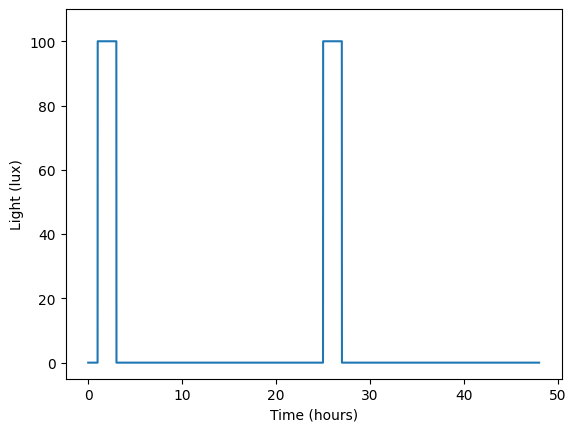

In [ ]:
#| hide
schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0, 24.0)
ax = schedule.plot(0.0, 48.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(-5, 110);

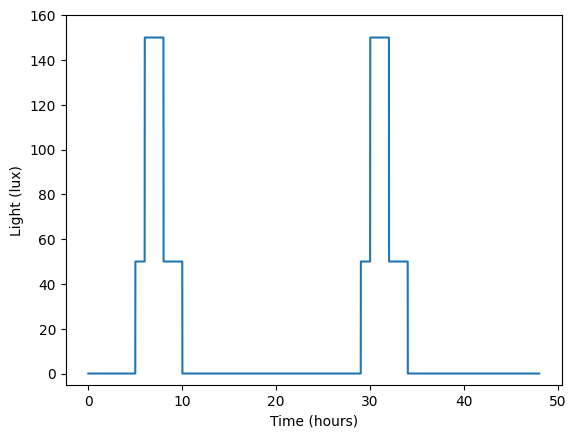

In [ ]:
#| hide
sum_schedule = LightSchedule.from_pulse(100.0, 6.0, 2.0, 24.0) + LightSchedule.from_pulse(50.0, 5.0, 5.0, 24.0)
ax = sum_schedule.plot(0.0, 48.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(-5, 160);

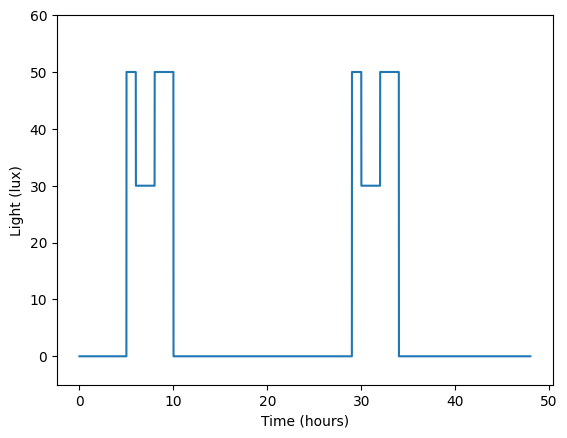

In [ ]:
#| hide
sum_schedule = LightSchedule.from_pulse(50.0, 5.0, 5.0, 24.0) - LightSchedule.from_pulse(20.0, 6.0, 2.0, 24.0)
ax = sum_schedule.plot(0.0, 48.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(-5, 60);

In [ ]:
#| export
@patch_to(LightSchedule)
def RegularLight(lux: float=150.0, # intensity of the light in lux
                 lights_on: float=7.0, # time of the day for lights to come on in hours
                 lights_off: float=23.0, # time of the day for lights to go off in hours
                 ) -> 'LightSchedule':
    "Create a regular light and darkness 24 hour schedule"
    # type checking
    if not isinstance(lux, (float, int)):
        raise TypeError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(lights_on, (float, int)):
        raise TypeError(f"lights_on must be a float or int, got {type(lights_on)}")
    elif lights_on < 0.0 or lights_on > 24.0:
        raise ValueError(f"lights_on must be between 0.0 and 24.0, got {lights_on}")
    if not isinstance(lights_off, (float, int)):
        raise TypeError(f"lights_off must be a float or int, got {type(lights_off)}")
    elif lights_off < 0.0 or lights_off > 24.0:
        raise ValueError(f"lights_off must be between 0.0 and 24.0, got {lights_off}")
    
    if lights_off > lights_on:
        schedule = LightSchedule.from_pulse(lux, lights_on, lights_off - lights_on, 24.0)
        return schedule
    elif lights_off < lights_on:
        schedule = LightSchedule.from_pulse(lux, lights_on, 24.0 - lights_on, 24.0)
        schedule = schedule + LightSchedule.from_pulse(lux, 0.0, lights_off, 24.0)
        return schedule
    elif lights_off == lights_on:
        raise ValueError("lights_off and lights_on cannot be equal")

In [ ]:
#| hide
# test RegularLight
time = np.linspace(0.0, 48.0, 1000)
# correct creation of standard RegularLight
regular_light = LightSchedule.RegularLight()
test_eq(np.all(regular_light(time[time < 7.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0) & (time <= 23.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 7.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0 + 24.0) & (time <= 23.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of RegularLight with custom lux
regular_light = LightSchedule.RegularLight(lux=100.0)
test_eq(np.all(regular_light(time[time < 7.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0) & (time <= 23.0)]) == 100.0), True)
test_eq(np.all(regular_light(time[(time > 23.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 7.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0 + 24.0) & (time <= 23.0 + 24.0)]) == 100.0), True)
test_eq(np.all(regular_light(time[(time > 23.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of RegularLight with custom lights_on
regular_light = LightSchedule.RegularLight(lights_on=6.0)
test_eq(np.all(regular_light(time[time < 6.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0) & (time <= 23.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 6.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0 + 24.0) & (time <= 23.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of RegularLight with custom lights_off
regular_light = LightSchedule.RegularLight(lights_off=18.0)
test_eq(np.all(regular_light(time[time < 7.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0) & (time <= 18.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 18.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 7.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0 + 24.0) & (time <= 18.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 18.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of RegularLight with custom lights_on > lights_off
regular_light = LightSchedule.RegularLight(lights_on=18.0, lights_off=6.0)
test_eq(np.all(regular_light(time[time < 6.0]) == 150.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0) & (time <= 18.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time > 18.0) & (time < 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 6.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0 + 24.0) & (time <= 18.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time > 18.0 + 24.0) & (time < 24.0 + 24.0)]) == 150.0), True)
# Tests: Type checking
test_fail(lambda: LightSchedule.RegularLight(lux='a'), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.RegularLight(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.RegularLight(lights_on='a'), contains="lights_on must be a float or int")
test_fail(lambda: LightSchedule.RegularLight(lights_on=-1.0), contains="lights_on must be between 0.0 and 24.0")
test_fail(lambda: LightSchedule.RegularLight(lights_on=25.0), contains="lights_on must be between 0.0 and 24.0")
test_fail(lambda: LightSchedule.RegularLight(lights_off='a'), contains="lights_off must be a float or int")
test_fail(lambda: LightSchedule.RegularLight(lights_off=-1.0), contains="lights_off must be between 0.0 and 24.0")
test_fail(lambda: LightSchedule.RegularLight(lights_off=25.0), contains="lights_off must be between 0.0 and 24.0")

In [ ]:
#| export
@patch_to(LightSchedule)
def ShiftWorkLight(lux: float=150.0, # lux intensity of the light. Must be a nonnegative float or int
                   days_on: int=5, # number of days on the night shift. Must be a positive int
                   days_off: int=2, # number of days off shift. Must be a positive int
                   lights_on_workday: float=17.0, # hour of the day for lights to come on on a workday. Must be between 0.0 and 24.0
                   lights_off_workday: float=9.0, # hour of the day for lights to go off on a workday. Must be between 0.0 and 24.0
                   lights_on_day_off: float=9.0, # hour of the day for lights to come on on a day off. Must be between 0.0 and 24.0
                   lights_off_day_off: float=24.0, # hour of the day for lights to go off on a day off. Must be between 0.0 and 24.0
                   ) -> 'LightSchedule':
    "Create a light schedule for a shift worker" 
    # type checking
    lux_err_msg = "lux must be a nonnegative float or int, got "
    if not isinstance(lux, (float, int)):
        raise TypeError(lux_err_msg + f"{type(lux)}")
    elif lux < 0.0:
        raise ValueError(lux_err_msg + f"{lux}")
    days_on_err_msg = "days_on must be an int > 1, got "
    if not isinstance(days_on, int):
        raise TypeError(days_on_err_msg + f"{type(days_on)}")
    elif days_on < 2:
        raise ValueError(days_on_err_msg + f"{days_on}")
    days_off_err_msg = "days_off must be an int > 1, got "
    if not isinstance(days_off, int):
        raise TypeError(days_off_err_msg + f"{type(days_off)}")
    elif days_off < 2:
        raise ValueError(days_off_err_msg + f"{days_off}")
    lights_on_workday_err_msg = "lights_on_workday must be a float or int between 0.0 and 24.0, got "
    if not isinstance(lights_on_workday, (float, int)):
        raise TypeError(lights_on_workday_err_msg + f"{type(lights_on_workday)}")
    elif lights_on_workday < 0.0 or lights_on_workday > 24.0:
        raise ValueError(lights_on_workday_err_msg + f"{lights_on_workday}")
    lights_off_workday_err_msg = "lights_off_workday must be a float or int between 0.0 and 24.0, got "
    if not isinstance(lights_off_workday, (float, int)):
        raise TypeError(lights_off_workday_err_msg + f"{type(lights_off_workday)}")
    elif lights_off_workday < 0.0 or lights_off_workday > 24.0:
        raise ValueError(lights_off_workday_err_msg + f"{lights_off_workday}")
    lights_on_day_off_err_msg = "lights_on_day_off must be a float or int between 0.0 and 24.0, got "
    if not isinstance(lights_on_day_off, (float, int)):
        raise TypeError(lights_on_day_off_err_msg + f"{type(lights_on_day_off)}")
    elif lights_on_day_off < 0.0 or lights_on_day_off > 24.0:
        raise ValueError(lights_on_day_off_err_msg + f"{lights_on_day_off}")
    lights_off_day_off_err_msg = "lights_off_day_off must be a float or int between 0.0 and 24.0, got "
    if not isinstance(lights_off_day_off, (float, int)):
        raise TypeError(lights_off_day_off_err_msg + f"{type(lights_off_day_off)}")
    elif lights_off_day_off < 0.0 or lights_off_day_off > 24.0:
        raise ValueError(lights_off_day_off_err_msg + f"{lights_off_day_off}")
    workweek_period = 24.0 * (days_on + days_off)
    # work days regular schedule
    work_schedule = LightSchedule.RegularLight(lux, lights_on_workday, lights_off_workday)
    # transition between work days and day off - sleep half of the time between `lights_off_workday` and `lights_on_day_off`
    workdays_finish = 24*(days_on - 1) + lights_on_workday
    first_transition_end = 24*days_on + lights_on_day_off
    transition_sleep_time = 0.5 * (workdays_finish + first_transition_end) - workdays_finish
    transition_day = LightSchedule.from_pulse(lux, workdays_finish, transition_sleep_time)
    # days off regular schedule
    days_off_schedule = LightSchedule.RegularLight(lux, lights_on_day_off, lights_off_day_off)
    # transition between day off and work day - sleep, in two chunks, a third of what's left until next workday
    second_transition_start = 24*(days_on + days_off - 2) + lights_off_day_off 
    workdays_start_again = 24*(days_on + days_off - 1) + lights_on_workday
    sleep_bank = (workdays_start_again - second_transition_start) / 3.0
    transition_sleep = LightSchedule.from_pulse(lux, second_transition_start + sleep_bank, sleep_bank, workweek_period)
    # create the schedule
    total_schedule = work_schedule.concatenate_at(transition_day, workdays_finish, shift_schedule=False)
    total_schedule = total_schedule.concatenate_at(days_off_schedule, first_transition_end, shift_schedule=False)
    total_schedule = total_schedule.concatenate_at(transition_sleep, second_transition_start, shift_schedule=False)
    total_schedule = total_schedule.concatenate_at(work_schedule, workdays_start_again, shift_schedule=False)
    # add workweek periodicity
    final_schedule = LightSchedule(total_schedule, period=workweek_period)
    return final_schedule

In [ ]:
#| hide
# test ShiftWorkLight
# correct creation of standard ShiftWorkLight
shift_work_light = LightSchedule.ShiftWorkLight()
def ground_truth_shift_schedule(time):
    lux = 150.0 
    days_on = 5 
    days_off = 2
    t = np.mod(time, 24*(days_on + days_off))
    lights_on_workday = 17.0
    lights_off_workday = 9.0
    lights_on_day_off = 9.0
    lights_off_day_off = 24.0
    workdays_finish = 24*(days_on - 1) + lights_on_workday
    first_transition_end = 24*days_on + lights_on_day_off
    second_transition_start = 24*(days_on + days_off - 2) + lights_off_day_off 
    workdays_start_again = 24*(days_on + days_off - 1) + lights_on_workday
    if t < workdays_finish:
        # work days
        schedule = LightSchedule.RegularLight(lux, lights_on_workday, lights_off_workday)
        return schedule(time)
    elif t >= workdays_finish and t < first_transition_end:
        # transition from workday to day off
        sleep_time = 0.5 * (workdays_finish + first_transition_end)
        if t < sleep_time:
            return lux
        else:
            return 0.0
    elif t >= first_transition_end and t < second_transition_start:
        # days off
        schedule = LightSchedule.RegularLight(lux, lights_on_day_off, lights_off_day_off)
        return schedule(time)
    elif t >= second_transition_start and t < workdays_start_again:
        # transition from day off to workday
        sleep_bank = (24*(days_on + days_off - 1) + lights_on_workday - second_transition_start) / 3.0
        schedule = LightSchedule.from_pulse(lux, second_transition_start + sleep_bank, sleep_bank, 24*(days_on + days_off))
        return schedule(time)
    else:
        # work days
        schedule = LightSchedule.RegularLight(lux, lights_on_workday, lights_off_workday)
        return schedule(time)

time = np.linspace(0.0, 3* 24*(5+2), 5000)
ground_truth_shift_schedule = np.vectorize(ground_truth_shift_schedule, otypes=[float])
test_eq(shift_work_light(time), ground_truth_shift_schedule(time))
# test error handling
test_fail(lambda: LightSchedule.ShiftWorkLight(lux='a'), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.ShiftWorkLight(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.ShiftWorkLight(days_on='a'), contains="days_on must be an int > 1")
test_fail(lambda: LightSchedule.ShiftWorkLight(days_on=-1), contains="days_on must be an int > 1")
test_fail(lambda: LightSchedule.ShiftWorkLight(days_off='a'), contains="days_off must be an int > 1")
test_fail(lambda: LightSchedule.ShiftWorkLight(days_off=-1), contains="days_off must be an int > 1") 
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_on_workday='a'), contains="lights_on_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_on_workday=-1.0), contains="lights_on_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_on_workday=25.0), contains="lights_on_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_off_workday='a'), contains="lights_off_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_off_workday=-1.0), contains="lights_off_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_off_workday=25.0), contains="lights_off_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_on_day_off='a'), contains="lights_on_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_on_day_off=-1.0), contains="lights_on_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_on_day_off=25.0), contains="lights_on_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_off_day_off='a'), contains="lights_off_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_off_day_off=-1.0), contains="lights_off_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWorkLight(lights_off_day_off=25.0), contains="lights_off_day_off must be a float or int between 0.0 and 24.0")

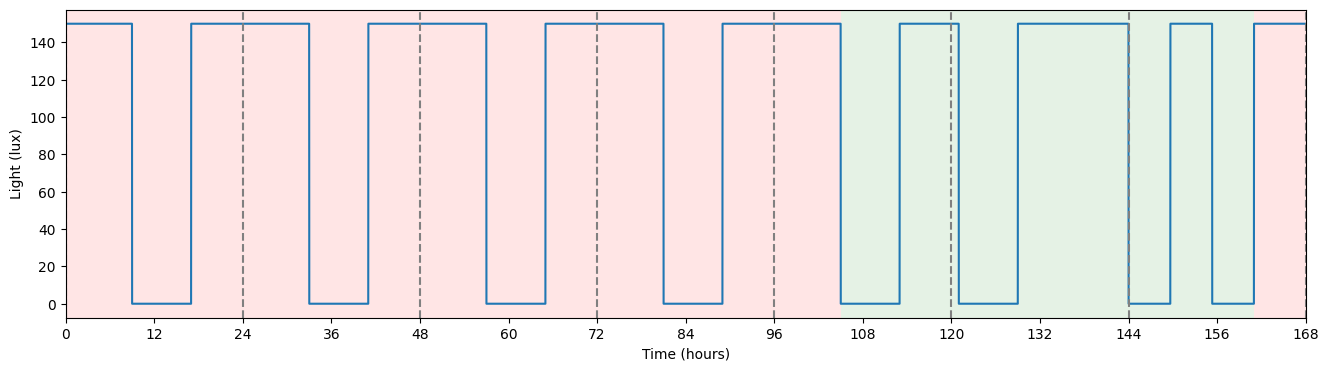

In [ ]:
#| hide
shift_schedule = LightSchedule.ShiftWorkLight()
days_on = 5
days_off = 2
lights_off_workday = 9.0
lights_on_workday = 17.0
ax = shift_schedule.plot(0.0, 24.0*8.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
# Add a vertical line to the start of each day in dashed gray
for day in range(8):
    ax.axvline(day*24.0, color='gray', linestyle='--');
ax.figure.set_size_inches(16, 4);
# Set xticks to mark each day
ax.set_xticks(np.arange(0, 24.0*8.0, 12));
# Set background color to light red for workdays until `lights_off_workday` on the last day
time_last_workday = lights_off_workday + 24*(days_on-1)
ax.axvspan(0.0, time_last_workday, facecolor='r', alpha=0.1);
# Set background color to light green for days off
time_last_day_off = lights_on_workday + 24.0*(days_on + days_off - 1)
ax.axvspan(time_last_workday, time_last_day_off, facecolor='g', alpha=0.1);
# Set background color to light red for the start of the workday in the last day
time_first_workday = time_last_day_off + lights_on_workday
ax.axvspan(time_last_day_off, time_first_workday, facecolor='r', alpha=0.1);
# Set limits to be a week
ax.set_xlim(0.0, 24.0*7.0);

In [ ]:
#| export
@patch_to(LightSchedule)
def SlamShift(lux: float=150.0, # intensity of the light in lux
              shift: float=8.0, # shift in the light schedule in hours
              before_days: int=10, # days before the shift occurs 
              starting_lights_on: float=7.0, # time of the day for lights to come on
              starting_lights_off: float=23.0, # time of the day for lights to go off
              ) -> 'LightSchedule':
    "Create a light schedule for a shift worker under a slam shift" 
    # type checking
    if not isinstance(lux, (float, int)):
        raise ValueError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(shift, (float, int)):
        raise ValueError(f"shift must be a nonnegative float or int, got {type(shift)}")
    elif shift < 0.0:
        raise ValueError(f"shift must be a nonnegative float or int, got {shift}")
    if not isinstance(before_days, int):
        raise ValueError(f"before_days must be a nonnegative int, got {type(before_days)}")
    elif before_days < 0:
        raise ValueError(f"before_days must be a nonnegative int, got {before_days}")
    if not isinstance(starting_lights_on, (float, int)):
        raise ValueError(f"starting_lights_on must be a float or int between 0 and 24, got {type(starting_lights_on)}")
    elif starting_lights_on < 0.0 or starting_lights_on > 24.0:
        raise ValueError(f"starting_lights_on must be a float or int between 0 and 24, got {starting_lights_on}")
    if not isinstance(starting_lights_off, (float, int)):
        raise ValueError(f"starting_lights_off must be a float or int between 0 and 24, got {type(starting_lights_off)}")
    elif starting_lights_off < 0.0 or starting_lights_off > 24.0:
        raise ValueError(f"starting_lights_off must be a float or int between 0 and 24, got {starting_lights_off}")
    # create the schedule
    schedule_before = LightSchedule.RegularLight(lux, starting_lights_on, starting_lights_off)
    last_lights_off_before = 24.0 * (before_days - 1) + starting_lights_off 
    first_lights_on_after =  24.0 * before_days + starting_lights_on + shift
    # sleep one third of the time between `last_lights_off_before` and `first_lights_on_after`
    transition_sleep_time =  (first_lights_on_after - last_lights_off_before) / 3.0
    transition_schedule = LightSchedule.from_pulse(lux, last_lights_off_before + transition_sleep_time, transition_sleep_time)
    shifted_lights_on = np.mod(starting_lights_on + shift, 24.0)
    shifted_lights_off = np.mod(starting_lights_off + shift, 24.0)
    schedule_after = LightSchedule.RegularLight(lux, shifted_lights_on, shifted_lights_off)
    final_schedule = schedule_before.concatenate_at(transition_schedule, last_lights_off_before, shift_schedule=False)
    final_schedule = final_schedule.concatenate_at(schedule_after, first_lights_on_after, shift_schedule=False)
    return final_schedule

In [ ]:
#| hide
# test SlamShift
slam_shift = LightSchedule.SlamShift()
def ground_truth_slam_shift(time):
    shift = 8.0
    before_days = 10
    starting_lights_on = 7.0
    starting_lights_off = 23.0
    last_lights_off_before = 24.0 * (before_days - 1) + starting_lights_off 
    first_lights_on_after =  24.0 * before_days + starting_lights_on + shift
    t = np.mod(time, 24.0)
    if time < last_lights_off_before:
        # before transition
        if t < 7.0:
            return 0.0
        elif t >= 7.0 and t <= 23.0:
            return 150.0
        else:
            return 0.0        
    elif time >= last_lights_off_before and time < first_lights_on_after:
        # transition
        third = (first_lights_on_after - last_lights_off_before) / 3.0
        light_start = last_lights_off_before + third
        if time <= light_start:
            return 0.0
        elif time >  light_start and time <= light_start + third:
            return 150.0
        else:
            return 0.0
    elif time >= first_lights_on_after:
        # after transition
        t = np.mod(time - shift, 24.0)
        if t < 7.0:
            return 0.0
        elif t >= 7.0 and t <= 23.0:
            return 150.0
        else:
            return 0.0
        
ground_truth_slam_shift = np.vectorize(ground_truth_slam_shift, otypes=[float])
test_eq(slam_shift(time), ground_truth_slam_shift(time))
# test error handling
test_fail(lambda: LightSchedule.SlamShift(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(shift="a"), contains="shift must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(shift=-1.0), contains="shift must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(before_days="a"), contains="before_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SlamShift(before_days=-1), contains="before_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_on="a"), contains="starting_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_on=-1.0), contains="starting_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_on=25.0), contains="starting_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_off="a"), contains="starting_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_off=-1.0), contains="starting_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_off=25.0), contains="starting_lights_off must be a float or int between 0 and 24")

In [ ]:
#| export
@patch_to(LightSchedule)
def SocialJetlag(lux: float=150.0, # intensity of the light in lux
                 num_regular_days: int=5, # number of days with a regular schedule
                 num_jetlag_days: int=2, # number of days with a delayed schedule
                 hours_delayed: float=2.0, # number of hours to delay the schedule on the jetlag days
                 regular_days_lights_on: float=7.0, # hour of the day for lights to come on
                 regular_days_lights_off: float=23.0, # hour of the day for lights to go off
                 ) -> 'LightSchedule':
    "Create a light schedule that simulates the effects of staying up late on the weekend (social jetlag)"
    # type checking
    if not isinstance(lux, (float, int)):
        raise TypeError(f"lux must be a nonnegative float or int, got {type(lux)}")
    elif lux < 0.0:
        raise ValueError(f"lux must be a nonnegative float or int, got {lux}")
    if not isinstance(num_regular_days, int):
        raise TypeError(f"num_regular_days must be a nonnegative int, got {type(num_regular_days)}")
    elif num_regular_days < 0:
        raise ValueError(f"num_regular_days must be a nonnegative int, got {num_regular_days}")
    if not isinstance(num_jetlag_days, int):
        raise TypeError(f"num_jetlag_days must be a nonnegative int, got {type(num_jetlag_days)}")
    elif num_jetlag_days < 0:
        raise ValueError(f"num_jetlag_days must be a nonnegative int, got {num_jetlag_days}")
    if not isinstance(hours_delayed, (float, int)):
        raise TypeError(f"hours_delayed must be a nonnegative float or int, got {type(hours_delayed)}")
    elif hours_delayed < 0.0:
        raise ValueError(f"hours_delayed must be a nonnegative float or int, got {hours_delayed}")
    if not isinstance(regular_days_lights_on, (float, int)):
        raise TypeError(f"regular_days_lights_on must be a float or int between 0 and 24, got {type(regular_days_lights_on)}")
    elif regular_days_lights_on < 0.0 or regular_days_lights_on > 24.0:
        raise ValueError(f"regular_days_lights_on must be a float or int between 0 and 24, got {regular_days_lights_on}")
    if not isinstance(regular_days_lights_off, (float, int)):
        raise TypeError(f"regular_days_lights_off must be a float or int between 0 and 24, got {type(regular_days_lights_off)}")
    elif regular_days_lights_off < 0.0 or regular_days_lights_off > 24.0:
        raise ValueError(f"regular_days_lights_off must be a float or int between 0 and 24, got {regular_days_lights_off}")
    # create the schedule 
    overall_period = 24.0 * (num_regular_days + num_jetlag_days)
    regular_days = LightSchedule.RegularLight(lux, lights_on=regular_days_lights_on, lights_off=regular_days_lights_off)
    jetlag_days = LightSchedule.RegularLight(lux, lights_on=regular_days_lights_on + hours_delayed,
                                             lights_off=np.mod(regular_days_lights_off + hours_delayed, 24))
    timepoint_change = 24.0 * (num_regular_days - 1) + regular_days_lights_off
    total_schedule = regular_days.concatenate_at(jetlag_days, timepoint_change, shift_schedule=False)
    final_schedule = LightSchedule(total_schedule, period=overall_period)
        
    return final_schedule

In [ ]:
#| hide
# test SocialJetlag
social_jetlag = LightSchedule.SocialJetlag()
def ground_truth_social_jetlag(time):
    lux = 150.0
    num_regular_days = 5
    num_jetlag_days = 2
    hours_delayed = 2.0
    regular_days_lights_on = 7.0
    regular_days_lights_off = 23.0
    overall_period = 24.0 * (num_regular_days + num_jetlag_days)
    timepoint_change = 24.0 * (num_regular_days - 1) + regular_days_lights_off
    t = np.mod(time, 24)
    if np.mod(time, overall_period) <= timepoint_change:
        # regular days
        if t <= regular_days_lights_on:
            return 0.0
        elif t > regular_days_lights_on and t < regular_days_lights_off:
            return lux
        else:
            return 0.0
    else:
        # jetlag days
        if t < np.mod(regular_days_lights_off + hours_delayed, 24):
            return lux
        if t >= np.mod(regular_days_lights_off + hours_delayed, 24) and t < regular_days_lights_on + hours_delayed:
            return 0.0
        elif t >= regular_days_lights_on + hours_delayed:
            return lux
        
ground_truth_social_jetlag = np.vectorize(ground_truth_social_jetlag, otypes=[float])
test_eq(social_jetlag(time), ground_truth_social_jetlag(time))
# test error handling
test_fail(lambda: LightSchedule.SocialJetlag(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(num_regular_days="a"), contains="num_regular_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(num_regular_days=-1), contains="num_regular_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(num_jetlag_days="a"), contains="num_jetlag_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(num_jetlag_days=-1), contains="num_jetlag_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(hours_delayed="a"), contains="hours_delayed must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(hours_delayed=-1.0), contains="hours_delayed must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_on="a"), contains="regular_days_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_on=-1.0), contains="regular_days_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_on=25.0), contains="regular_days_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_off="a"), contains="regular_days_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_off=-1.0), contains="regular_days_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_off=25.0), contains="regular_days_lights_off must be a float or int between 0 and 24")

In [ ]:
#| export
# TODO: Replace the use of these two functions with LightSchedules
def make_pulse(t, tstart, tend, steep: float=30.0):
    return 0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-tend))

def get_pulse(t: float,
              t1: float,
              t2: float,
              repeat=False,
              Intensity: float = 150.0):

    if repeat:
        t = np.fmod(t, 24.0)
    if t < 0.0:
        t += 24.0

    light_value = Intensity*make_pulse(t, t1, t2)
    return np.abs(light_value)

# Overview

The `LightSchedule` class streamlines the process of creating light schedules for circadian models. Each LightSchedule behaves as a function that returns specific lux values for each timepoint. `LightSchedule` objects can be added, subtracted, and concatenated between each other.

# Creating and visualizing light schedules

We can create and plot a schedule that contains a single pulse of light using the following code

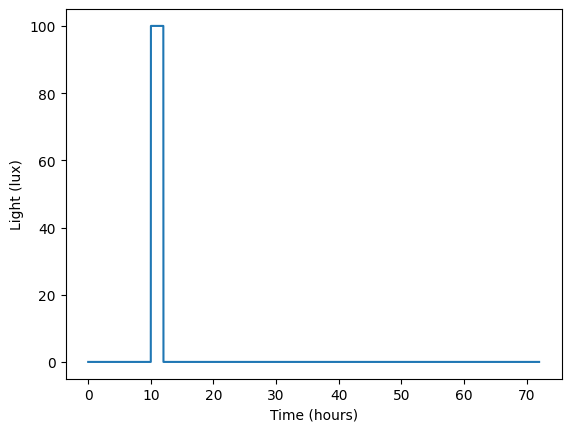

In [ ]:
single_pulse = LightSchedule.from_pulse(100.0, start=10.0, duration=2.0)
ax = single_pulse.plot(0.0, 72.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

The value of the light schedule outside of the pulse can be adjusted with the `default_value` parameter

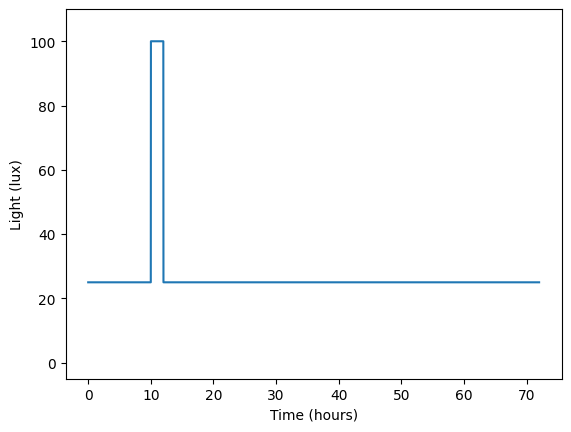

In [ ]:
baseline_pulse = LightSchedule.from_pulse(100.0, start=10.0, duration=2.0, baseline=25.0)
ax = baseline_pulse.plot(0.0, 72.0)
ax.set_ylim(-5, 110);
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

The resulting object is callable and returns the value of the schedule at the given times 

In [ ]:
times = np.linspace(0.0, 24.0, 10)
print(baseline_pulse(times))

[ 25.  25.  25.  25. 100.  25.  25.  25.  25.  25.]


When calling the object, the keyword argument `repeat_period` can be specified to get an array where the schedule repeats at a given interval

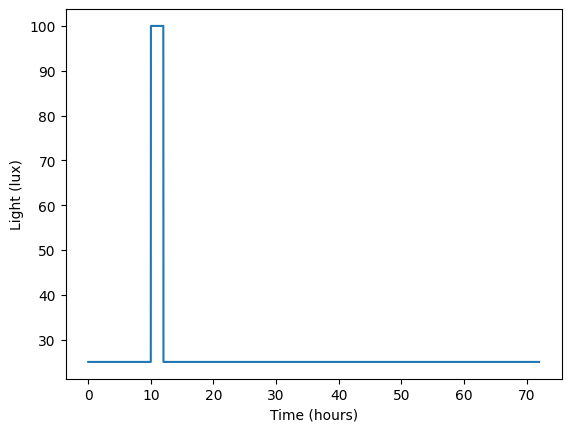

In [ ]:
times = np.linspace(0.0, 72.0, 10000)
repeating_schedule = baseline_pulse(times)
plt.plot(times, repeating_schedule)
plt.xlabel('Time (hours)');
plt.ylabel('Light (lux)');

If the array of light values is not needed and only a plot is desired, the `plot` method with the `repeat_period` argument can be used to obtain the same plot as above

```python
ax = baseline_pulse.plot(0.0, 72.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
```

Custom light schedules can be created by providing a function when instantiating a `Light` object. Here, we define a light schedule that ramps up and down over a 12 hour period.

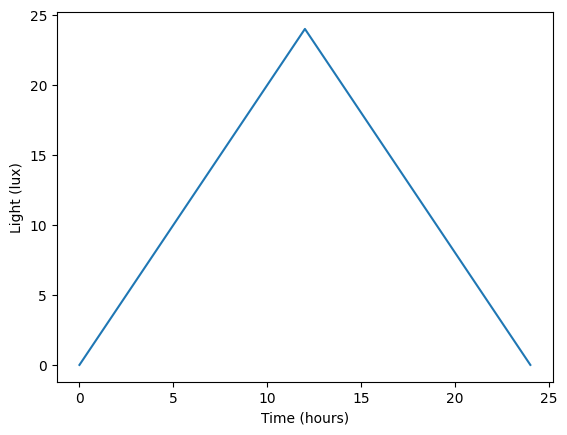

In [ ]:
def ramp(t):
    if t < 12.0:
        return 2.0*t
    else:
        return 2.0*(24.0 - t)

ramp_schedule = LightSchedule(ramp)
ax = ramp_schedule.plot(0.0, 24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

# Adding light schedules together

`Light` objects can be combined using the `+` operator. For example, we can add `baseline_pulse` and `ramp_schedule` defined before 

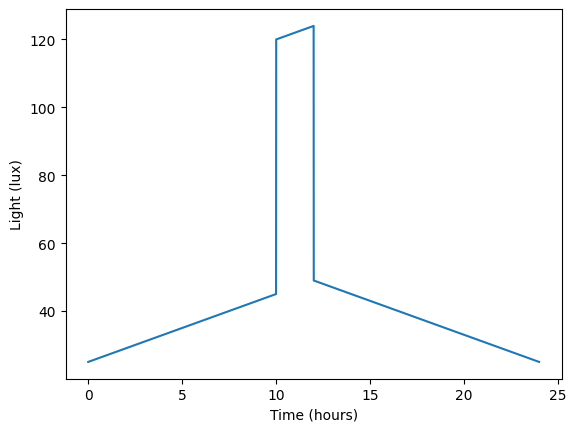

In [ ]:
combined_schedule = baseline_pulse + ramp_schedule
ax = combined_schedule.plot(0.0, 24.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

# Helper functions for typical light schedules

The `Light` class implements several helper functions to obtain common light schedules. For example, to generate a light schedule that mimics the light intensity of a typical day, we can use the `LightSchedule.RegularLight` function

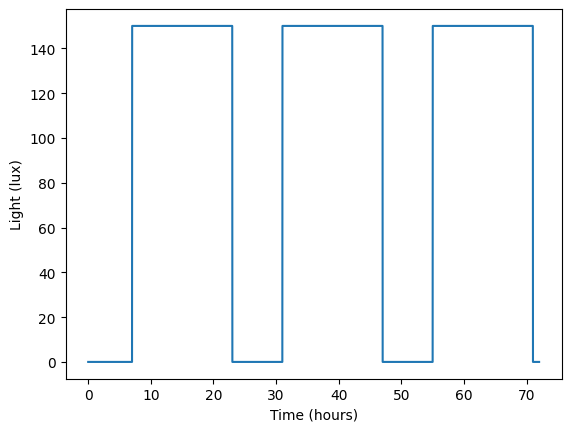

In [ ]:
regular_light = LightSchedule.RegularLight()
ax = regular_light.plot(0.0, 72.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

The `LightSchedule.RegularLight` function can be customized via three parameters: `lux`, `lights_on`, and `lights_off`. The `lux` parameter defines the light intensity during the day, while `lights_on` and `lights_off` define the time of day when the lights turn on and off, respectively.

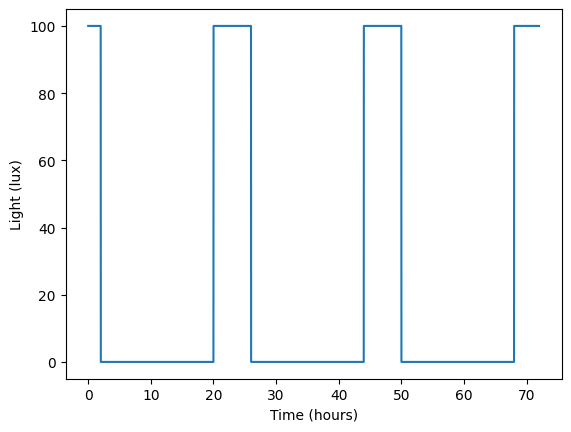

In [ ]:
custom_regular_light = LightSchedule.RegularLight(lux=100.0, lights_on=20.0, lights_off=2.0)
ax = custom_regular_light.plot(0.0, 72.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');

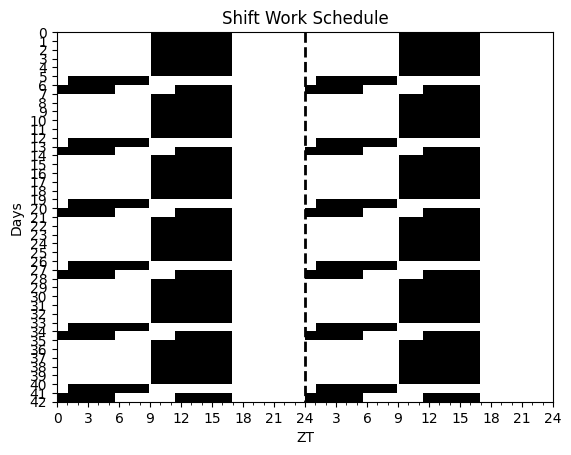

In [ ]:
#| hide
sw_light = LightSchedule.ShiftWorkLight(days_on=5, days_off=2)
ts = np.arange(0, 24*7*6, 0.10)
light_values = sw_light(ts)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Shift Work Schedule");

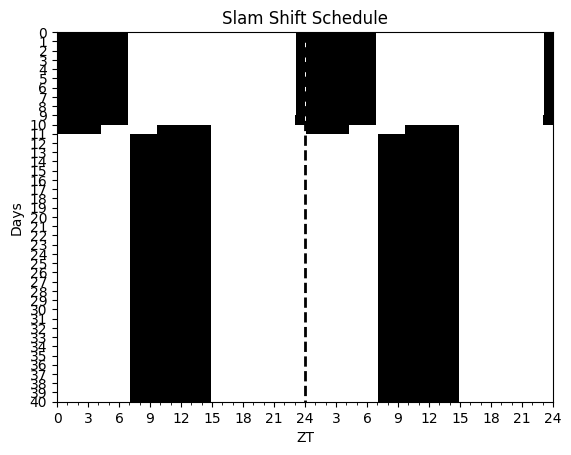

In [ ]:
#| hide
slam_shift = LightSchedule.SlamShift()
ts = np.arange(0, 24*40, 0.10)
light_values = slam_shift(ts)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Slam Shift Schedule");

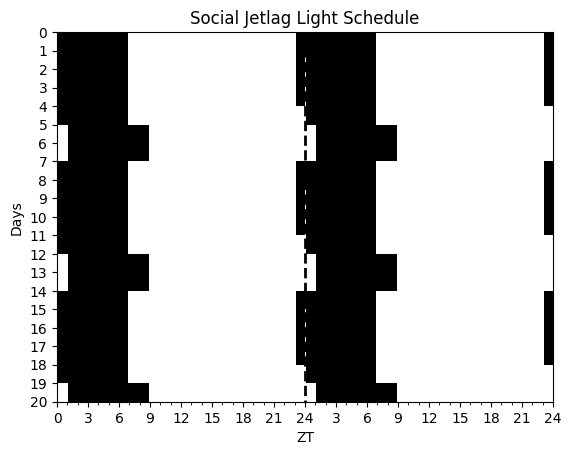

In [ ]:
#| hide
social_jl = LightSchedule.SocialJetlag()
ts = np.arange(0, 24*20, 0.10)
light_values = social_jl(ts)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Social Jetlag Light Schedule");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()